In [1]:
# cofing: utf-8
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow


# https://stackoverrun.com/ja/q/9332348
# custom loss 

In [2]:
# データの前処理
import os
import sklearn
import sklearn.model_selection
from tensorflow.keras.utils import to_categorical
batch_size = 100 # データの大きさ reshapeしてからshapeの形求める感じでやろう
timesteps = 256
input_dim = 3 # acc (x, y, z)
num_classes = 6 # 分類数

x_train, y_train, x_test, y_test = (1, 1, 1, 1)


In [3]:
# データの読み込み
home_dir = os.path.expanduser("~")
label_path = home_dir + "/Desktop/hasc_data/y_large3.csv"
data_path  = home_dir + "/Desktop/hasc_data/x_large3.csv"

label_df = pd.read_csv(label_path, index_col=0)
data_np  = np.loadtxt (data_path , delimiter=",").reshape(-1, timesteps, input_dim)

In [4]:
# label の取り扱い
# 0 to 5 :  6 class
labels = label_df["act"] - 1
print(labels)

0        0
1        0
2        0
3        0
4        0
        ..
36866    5
36867    5
36868    5
36869    5
36870    5
Name: act, Length: 36871, dtype: int64


In [5]:
# データ分割

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(data_np, labels, test_size = 0.2, train_size=None, stratify=labels)

y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

num_classes = len(labels.unique())
batch_size = x_train.shape[0]
print(num_classes, "classies validation")
print("train data len :", batch_size)
print("test  data len :", x_test.shape[0])

6 classies validation
train data len : 29496
test  data len : 7375


In [6]:
#preprocessing
# TODO
# ここもっと綺麗にしたい
# dict使って，MMSとStdSをうまく使えるようにしたい
from sklearn.preprocessing import MinMaxScaler, StandardScaler

MMScaler = MinMaxScaler()
StdScaler = StandardScaler()

datas = {"original" : [x_train, x_train]}
x_train_mms  = []
x_test_mms   = []
x_train_stds = []
x_test_stds  = []

for data in x_train:
    x = MMScaler.fit_transform(data)
    x_train_mms.append(x)
    x = StdScaler.fit_transform(data)
    x_train_stds.append(x)

for data in x_test:
    x = MMScaler.fit_transform(data)
    x_test_mms.append(x)
    x = StdScaler.fit_transform(data)
    x_test_stds.append(x)

x_train_mms  = np.array(x_train_mms )
x_test_mms   = np.array(x_test_mms  )
x_train_stds = np.array(x_train_stds)
x_test_stds  = np.array(x_test_stds )

datas["mms"] = [x_train_mms,  x_test_mms]
datas["stds"]= [x_train_stds, x_test_stds]


In [7]:
# TODO モデルを保存したdictを作ってうまく管理したい
# 今はモデル作ったやつをそのまま辞書の中に入れてるけど，コンパイルしてから入れたほうがいいかも？

models = {}

lstm_dontrun_input = Input( shape=( timesteps, input_dim ) )
lstm_dontrun_lstm1 = LSTM(units=256, activation="relu", kernel_initializer="he_normal", return_sequences=True, dropout=0.1)( lstm_dontrun_input )
lstm_dontrun_lstm2 = LSTM(units=128, activation="relu", kernel_initializer="he_normal", return_sequences=True, dropout=0.1)( lstm_dontrun_lstm1 )
lstm_dontrun_lstm3 = LSTM(units=64, activation="relu", kernel_initializer="he_normal",  return_sequences=True, dropout=0.1)( lstm_dontrun_lstm2 )
lstm_dontrun_lstm4 = LSTM(units=32, activation="relu", kernel_initializer="he_normal", dropout=0.1)( lstm_dontrun_lstm3 )
lstm_dontrun_dense = Dense(units=num_classes, activation="softmax")( lstm_dontrun_lstm4 )
model_lstm_dontrun = Model(inputs = lstm_dontrun_input, outputs=lstm_dontrun_dense, name="lstm_dontrun")
models["lstm_dontrun"] = model_lstm_dontrun

lstm_1_input = Input( shape=( timesteps, input_dim ) )
lstm_1_lstm = LSTM(units=32, activation="relu", kernel_initializer="he_normal",  return_sequences=False, dropout=0.1)( lstm_1_input )
lstm_1_dense = Dense(units=num_classes, activation="softmax")( lstm_1_lstm )
model_lstm_1 = Model(inputs = lstm_1_input, outputs = lstm_1_dense, name="lstm_1")
models["lstm_1"] = model_lstm_1

conv1_1_input = Input( shape=( timesteps, input_dim ) )
conv1_1_conv1 = Conv1D(filters=128, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_input)
conv1_1_pool1 = MaxPooling1D(4, padding='same')(conv1_1_conv1)
conv1_1_conv2 = Conv1D(filters=64, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_pool1)
conv1_1_pool2 = MaxPooling1D(1, padding='same')(conv1_1_conv2)
conv1_1_conv3 = Conv1D(filters=32, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_pool2)
conv1_1_conv4 = Conv1D(filters=16, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_conv3)
conv1_1_flatter = Flatten()(conv1_1_conv4)
conv1_1_dense = Dense(units=num_classes, activation="softmax")(conv1_1_flatter)
model_conv1_1 = Model(inputs=conv1_1_input, outputs=conv1_1_dense, name="conv1d_1")
models["conv1d_1"] = model_conv1_1



conv1_2_input = Input( shape=( timesteps, input_dim ) )
conv1_2_conv1 = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_2_input)
conv1_2_dropout1 = Dropout(0.25)(conv1_2_conv1)
# conv1_2_pool1 = MaxPooling1D(4, padding='same')(conv1_1_conv1)
conv1_2_conv2 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_2_dropout1)
conv1_2_dropout2 = Dropout(0.25)(conv1_2_conv2)
# conv1_2_pool2 = MaxPooling1D(1, padding='same')(conv1_1_conv2)
conv1_2_conv3 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_2_dropout2)
conv1_2_dropout3 = Dropout(0.25)(conv1_2_conv3)
conv1_2_conv4 = Conv1D(filters=256, kernel_size=3, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_2_dropout3)
conv1_2_dropout4 = Dropout(0.25)(conv1_2_conv4)
conv1_2_flatter = Flatten()(conv1_2_dropout4)
conv1_2_dense1 = Dense(units=2048, activation="relu")(conv1_2_flatter)
conv1_2_dense2 = Dense(units=num_classes, activation="softmax")(conv1_2_dense1)
model_conv1_2 = Model(inputs=conv1_2_input, outputs=conv1_2_dense2, name="conv1d_2")
models["conv1d_2"] = model_conv1_2


# 1d vgg16
vgg16_input = Input(shape=(timesteps, input_dim))

# block1
vgg16_block1_conv1 = Conv1D(filters=64, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_input)
vgg16_block1_bn1 = BatchNormalization()(vgg16_block1_conv1)
vgg16_block1_actiovation1 = Activation("relu")(vgg16_block1_bn1)
vgg16_block1_conv2 = Conv1D(filters=64, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block1_actiovation1)
vgg16_block1_bn2 = BatchNormalization()(vgg16_block1_conv2)
vgg16_block1_actiovation2 = Activation("relu")(vgg16_block1_bn2)
vgg16_block1_pool = MaxPooling1D(pool_size=2, strides=2, padding="same")(vgg16_block1_actiovation2)

# block2
vgg16_block2_conv1 = Conv1D(filters=128, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block1_pool)
vgg16_block2_bn1 = BatchNormalization()(vgg16_block2_conv1)
vgg16_block2_actiovation1 = Activation("relu")(vgg16_block2_bn1)
vgg16_block2_conv2 = Conv1D(filters=128, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block2_actiovation1)
vgg16_block2_bn2 = BatchNormalization()(vgg16_block2_conv2)
vgg16_block2_actiovation2 = Activation("relu")(vgg16_block2_bn2)
vgg16_block2_pool = MaxPooling1D(pool_size=2, strides=2, padding="same")(vgg16_block2_actiovation2)

# block3
vgg16_block3_conv1 = Conv1D(filters=256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block2_pool)
vgg16_block3_bn1 = BatchNormalization()(vgg16_block3_conv1)
vgg16_block3_actiovation1 = Activation("relu")(vgg16_block3_bn1)
vgg16_block3_conv2 = Conv1D(filters=256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block3_actiovation1)
vgg16_block3_bn2 = BatchNormalization()(vgg16_block3_conv2)
vgg16_block3_actiovation2 = Activation("relu")(vgg16_block3_bn2)
vgg16_block3_conv3 = Conv1D(filters=256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block3_actiovation2)
vgg16_block3_bn3 = BatchNormalization()(vgg16_block3_conv3)
vgg16_block3_actiovation3 = Activation("relu")(vgg16_block3_bn3)
vgg16_block3_pool = MaxPooling1D(pool_size=2, strides=2, padding="same")(vgg16_block3_actiovation3)

# block4
vgg16_block4_conv1 = Conv1D(filters=512, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block3_pool)
vgg16_block4_bn1 = BatchNormalization()(vgg16_block4_conv1)
vgg16_block4_actiovation1 = Activation("relu")(vgg16_block4_bn1)
vgg16_block4_conv2 = Conv1D(filters=512, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block4_actiovation1)
vgg16_block4_bn2 = BatchNormalization()(vgg16_block4_conv2)
vgg16_block4_actiovation2 = Activation("relu")(vgg16_block4_bn2)
vgg16_block4_conv3 = Conv1D(filters=256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block4_actiovation2)
vgg16_block4_bn3 = BatchNormalization()(vgg16_block4_conv3)
vgg16_block4_actiovation3 = Activation("relu")(vgg16_block4_bn3)
vgg16_block4_pool = MaxPooling1D(pool_size=2, strides=2, padding="same")(vgg16_block4_actiovation3)

# block5
vgg16_block5_conv1 = Conv1D(filters=512, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block4_pool)
vgg16_block5_bn1 = BatchNormalization()(vgg16_block5_conv1)
vgg16_block5_actiovation1 = Activation("relu")(vgg16_block5_bn1)
vgg16_block5_conv2 = Conv1D(filters=512, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block5_actiovation1)
vgg16_block5_bn2 = BatchNormalization()(vgg16_block5_conv2)
vgg16_block5_actiovation2 = Activation("relu")(vgg16_block5_bn2)
vgg16_block5_conv3 = Conv1D(filters=256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block5_actiovation2)
vgg16_block5_bn3 = BatchNormalization()(vgg16_block5_conv3)
vgg16_block5_actiovation3 = Activation("relu")(vgg16_block5_bn3)
vgg16_block5_pool = MaxPooling1D(pool_size=2, strides=2, padding="same")(vgg16_block5_actiovation3)

# dense
vgg16_flatten = Flatten()(vgg16_block5_pool)
vgg16_dense1  = Dense(units=4096, activation="relu")(vgg16_flatten)
vgg16_dense2  = Dense(units=4096, activation="relu")(vgg16_dense1)
vgg16_output  = Dense(units=num_classes, activation="softmax")(vgg16_dense2)
model_vgg16_1d = Model(inputs = vgg16_input, outputs=vgg16_output, name="vgg16_1d")
models["vgg16_1d"] = model_vgg16_1d

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
print("model list:")
for name in models.keys():
    print("・", name)

for model in models.values():
    print()
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
    print()

model list:
・ lstm_dontrun
・ lstm_1
・ conv1d_1
・ conv1d_2
・ vgg16_1d

Model: "lstm_dontrun"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 3)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 256, 256)          266240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256, 128)          197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256, 64)           49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 525,382
Trainable params: 525,382
No

In [9]:
"""
model_to_dotがうまく動かないのでこのセルは実行しないこと

from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog="dot", format="svg"))
"""

pass

In [10]:
# model_lstm.fit(x_train_mms, y_train, batch_size=batch_size//20, epochs=50, verbose=1, callbacks=[EarlyStopping(verbose=1)], validation_data=(x_test_mms, y_test))
# result = models["vgg16_1d"].fit(x_train_mms, y_train, batch_size=batch_size//20, epochs=50, verbose=1, validation_data=(x_test_mms, y_test))
mini_batch_size       = 2048 # free 
epoch                 = 50
callbacks             = [] # callback functions' list
train_data, test_data = datas["stds"] # original, mms, stds

result = models["vgg16_1d"].fit(train_data, y_train, batch_size=mini_batch_size, epochs=epoch, verbose=1, callbacks = callbacks, validation_data=(test_data, y_test))


Train on 29496 samples, validate on 7375 samples
Epoch 1/50
29496/29496 [==============================] - 517s 18ms/sample - loss: 4.9115 - acc: 0.1867 - val_loss: 1454.5993 - val_acc: 0.1627
Epoch 2/50
29496/29496 [==============================] - 491s 17ms/sample - loss: 1.7834 - acc: 0.2035 - val_loss: 35.0078 - val_acc: 0.1689
Epoch 3/50
29496/29496 [==============================] - 488s 17ms/sample - loss: 1.7013 - acc: 0.2461 - val_loss: 55.6738 - val_acc: 0.1627
Epoch 4/50
29496/29496 [==============================] - 496s 17ms/sample - loss: 1.4220 - acc: 0.3782 - val_loss: 2.8417 - val_acc: 0.2605
Epoch 5/50
29496/29496 [==============================] - 507s 17ms/sample - loss: 1.2654 - acc: 0.4423 - val_loss: 1.9538 - val_acc: 0.2305
Epoch 6/50
29496/29496 [==============================] - 487s 17ms/sample - loss: 1.2291 - acc: 0.4663 - val_loss: 1.8011 - val_acc: 0.2727
Epoch 7/50
29496/29496 [==============================] - 488s 17ms/sample - loss: 1.1481 - acc: 0.5

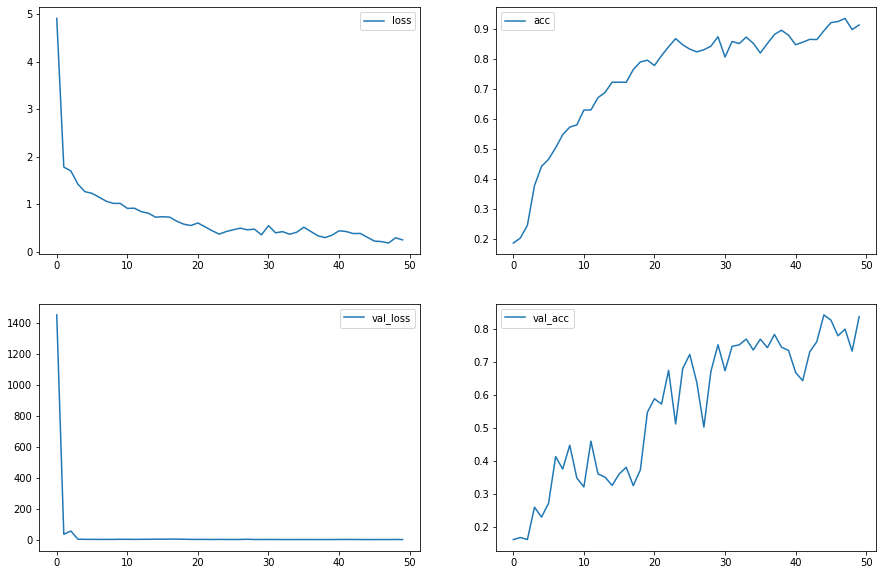

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
for i, key in enumerate(result.history.keys()):
    plt.subplot(2, 2, i + 1)
    plt.plot(result.history[key], label = key)
    plt.legend()

In [12]:
evals = models["vgg16_1d"].evaluate(test_data, y_test)
print("loss", evals[0])
print("acc",  evals[1])

NameError: name 'test_data' is not defined